## Flight finder from Ryanair website

#### 1. IMPORTS

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
import datetime
import pandas as pd
import numpy as np
import random
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import panel as pn
import warnings
warnings.filterwarnings("ignore")

import locale
print("Language time format:")
locale.setlocale(locale.LC_TIME,"es_ES")

Language time format:


'es_ES'

#### 2. FUNCTIONS

In [2]:
def myClick(ptime,by,desc):
    wait = WebDriverWait(driver, ptime)
    by = by.upper()
    if by == 'XPATH':
        return wait.until(EC.presence_of_element_located((By.XPATH, desc))).click()
    elif by == 'ID':
        return wait.until(EC.presence_of_element_located((By.ID, desc))).click()
    elif by == 'CLASS':
        return wait.until(EC.presence_of_element_located((By.CLASS_NAME, desc))).click()    
    elif by == 'LINK_TEXT':
        return wait.until(EC.presence_of_element_located((By.LINK_TEXT, desc))).click()

def text_fill(ptime,by,text_fill,desc):
    by = by.upper()
    wait = WebDriverWait(driver, ptime)    
    if by == 'XPATH':
        form = wait.until(EC.presence_of_element_located((By.XPATH, desc)))
#         form = driver.find_element_by_xpath(desc)
    form.send_keys(Keys.CONTROL + "a")
    return form.send_keys(text_fill)

def date_selec(input_date,elems,attlook,active_flag,attget):
    dates_act = []
    for elem in elems:
        if elem.get_attribute(attlook) == active_flag:
            dates_act.append(elem.get_attribute(attget))

    dates_act2 = []
    for i, date in enumerate(dates_act):
        dates_act2.append(datetime.datetime.strptime(date,'%Y-%m-%d'))

    return '"'+str(min(dates_act2, key=lambda sub: abs(sub - datetime.datetime.strptime(input_date.strip('""'),'%Y-%m-%d')))).strip(" 00:00:00")+'"'

def get_destinations_list(by,desc):
    by = by.upper()
    if by == "XPATH":
        destinations = driver.find_element_by_xpath(desc)
    dest_list = destinations.text.split("\n")
    try:
        dest_list.remove("NEW")
    except:
        pass
    try:
        dest_list.remove("Cualquier destino")
    except:
        pass
    try:
        dest_list = [x for x in dest_list if "Todos los aeropuertos" not in x]
    except:
        pass
    try:
        dest_list = [x for x in dest_list if "1 escala" not in x]
    except:
        pass
    for i,e in enumerate(dest_list):
        if " (Operado por" in e:
#             dest_list[i] = e[:e.find(" (Operated by")] # strip of operado por
           dest_list.remove(e) 
  
    return dest_list

def date_price(input_date,by,desc):
    by = by.upper()
    if by == "XPATH":    
        elem = driver.find_elements_by_xpath(desc)
    else:
        print("Specify element format")
    
    months = {'ene':'jan','feb':'feb','mar':'mar','abr':'apr','may':'may','jun':'jun','jul':'jul','ago':'aug','sep':'sep','oct':'oct','nov':'nov','dic':'dec'}
    list_dates = []
    price = {}
    d = {}
    for i,e in enumerate(elem):
        list_dates.append(e.text.replace("\n","").replace(",","."))
    
    list_dates = [x for x in list_dates if x] # Elimino elementos vacios para tener solo 5 indices
    
    for i,e in enumerate(list_dates):
        date_flight = list_dates[i][:2]+months[list_dates[i][2:5].lower()]
        if list_dates[i].find("€") != -1:
            price[i] = float(list_dates[i][list_dates[i].find("€")+1:])
            # d[i] = datetime.datetime.strptime(list_dates[i][:list_dates[i].find("€")],'%d%b%A').strftime(f'{input_date[1:5]}-%m-%d')
            d[i] = datetime.datetime.strptime(date_flight,'%d%b').strftime(f'{input_date[1:5]}-%m-%d')
        else:
            d[i] = datetime.datetime.strptime(date_flight,'%d%b').strftime(f'{input_date[1:5]}-%m-%d')
            
    l = []
    for i in price:
        if price[i] == min(price.values()):
            l.append(i)
            
    if len(l) > 1:
        return [min(l, key=lambda x:abs(x-2)),d[min(l, key=lambda x:abs(x-2))]] # Obtener el menor precio, mas cercano a la posicion inicial
    else:
        return [2,d[2]]

def flights_df(date,ptime,ind,by,desc):
    time.sleep(ptime)
    by = by.upper()
    if by == "XPATH":
        elem = driver.find_elements_by_xpath(desc)
    
    flights = []
    for e in elem:
        x = f"{ind}\n" + f"{date}\n" + e.text
        flights.append(x.replace(",",".").replace("\n",","))

    flights2 = []
    for i in range(len(flights)):
        if len(flights[i]) > 50:
        
            if flights[i].find("Quedan") !=-1 and flights[i].find("¿Qué") !=-1:
                flights2.append(flights[i][:flights[i].find("Quedan")-1] + flights[i][flights[i].find("¿Qué")+13:flights[i].find("Seleccion")-1])
                
            elif flights[i].find("Quedan") !=-1:    
                flights2.append(flights[i][:flights[i].find("Quedan")-1] + flights[i][flights[i].find("Tarifa")+12:flights[i].find("Seleccion")-1])
            
            elif flights[i].find("¿Qué") !=-1:
                flights2.append(flights[i][:flights[i].find("¿Qué")-14] + flights[i][flights[i].find("¿Qué")+13:flights[i].find("Seleccion")-1])                
    
            else:
                flights2.append(flights[i][:flights[i].find("Tarifa")-1] + flights[i][flights[i].find("Tarifa")+12:flights[i].find("Seleccion")-1])
                
    return pd.DataFrame([sub.split(",") for sub in flights2]).drop_duplicates()

#### 3. HEADER

1. Set exe files location and web site address.

Chrome driver and browser versions must be the same.

In [3]:
## CHROME DRIVER ROUTE
### Download it from here: https://chromedriver.chromium.org/downloads
chromepath = r'D:\PY\5_webscraping\Selenium\chromedriver.exe'

## CHROME APP
browser_path = r'C:\Program Files\Google\Chrome\Application\chrome.exe'

## BRAVE APP
# browser_path = r'C:\Program Files\BraveSoftware\Brave-Browser\Application\brave.exe'

html = 'https://www.ryanair.com/es/es'

2. Here is where you set origin and destination city (start and destination variables);


3. Then you can set exact destination or not if you don't know where to go and you are looking for the best oportunity regarding to price (exact_destination = True | False);


4. With dates is the same logic, there is a flag to look for exact dates or approximated ones (exact_dates = True | False)


5. Additionally you can look for more than one round trip dates (as a list).

In [4]:
start = "sevilla"
start = start.capitalize()

exact_destination = False

## Only if exact_destination == True. If it is False, it will search for all possible destinations.
destination = "Bari"
destination = destination.capitalize()

exact_dates = True

# yyyy/mm/dd
departure_dates = ['"2022-12-01"']
back_dates = ['"2022-12-11"'] 

month = datetime.datetime.strptime(departure_dates[0],'"%Y-%m-%d"').strftime("%b")
month = month.lower().strip(".")
if month == "sep":
    month = "sept"

ptimelow = round(random.uniform(1,2),2)
ptimehigh = round(random.uniform(3,4),2)

#### 4. MAIN BODY

In [7]:
%%time

# RESET RESULT DATAFRAMES
try:
    del flights_df_dep
    del flights_df_arrive
except:
    pass

chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("excludeSwitches", ['enable-automation'])
chrome_options.binary_location = browser_path
# RUN SILENTLY IN BACKGROUND
# chrome_options.add_argument("--headless")

driver = webdriver.Chrome(chromepath,options=chrome_options)
driver.get(html)

driver.delete_all_cookies()
driver.maximize_window()

#### COOKIES
myClick(ptimehigh,"XPATH", "/html/body/div/div/div[3]/button[2]")

#### SET FLIGHT SEARCH
#FROM
time.sleep(ptimehigh)
text_fill(ptimehigh,"xpath",start,"/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/fsw-flight-search-widget-controls-container/fsw-flight-search-widget-controls/div/fsw-input-button/div/input")
myClick(ptimehigh,"XPATH", "/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-origin-container/fsw-airports/div/fsw-airports-list/div[2]/div[1]/fsw-airport-item")


for departure_date in departure_dates:
    for back_date in back_dates:
        
        print(f""" 
        -------------------------------------------------------------
        
        "Searching flights from {departure_date} to {back_date}....."
        
        -------------------------------------------------------------
        """)
        
        #TO
        flag = True
        if exact_destination:
            while flag:
                time.sleep(ptimehigh)
                text_fill(ptimehigh,"xpath",destination,"/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/fsw-flight-search-widget-controls-container/fsw-flight-search-widget-controls/div/div/fsw-input-button/div/input")
            
                try:
                    myClick(ptimehigh,"XPATH","/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-destination-container/fsw-airports/div/fsw-airports-list/div[2]/div[1]/fsw-airport-item[2]")        
                except:
                    print(f"No existen conexiones para {start}-{destination}")
                    break
            
                #### SELECT DEPARTURE DATE
            
                #SELECT MONTH
                try:
                    myClick(ptimehigh,"XPATH",f'/html/body/ry-tooltip[1]/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop/month-toggle/div/div[2]//*[contains(text()," {month} ")]')
                except:
                    print(f"Mes de viaje no disponible para {start}-{destination}")
                    break
                    
                if exact_dates:
                    ## SELECT DAY 1
                    try:
                        time.sleep(ptimehigh)
                        myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date}]')
                    except:
                        print(f"No existen fechas exactas de ida para {start}-{destination}")
                        break
                        
                    ## SELECT DAY 2
                    try:
                        time.sleep(ptimehigh)
                        myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date}]')
                        flag = False
                    except:
                        print(f"No existen fechas exactas de regreso para {start}-{destination}")
                        break
                        
                    ## SELECT 2 adults
                    myClick(ptimehigh,"xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-passengers-container/fsw-passengers/fsw-passengers-picker-container/fsw-passengers-picker/ry-counter[1]/div[2]/div[3]')
                    
                    ## SEARCH BUTTON
                    myClick(ptimehigh,"xpath","/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")
                    
                    ## COOKIES
                    try:
                        myClick(ptimehigh,"xpath","/html/body/div/div/div[3]/button[2]")
                    except:
                        pass
                    
                    ## FLIGHTS OPTIONS
                    flights_df_dep = flights_df(departure_date,ptimehigh,"1","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')
                    print(f"Flight {start}-{destination} added")
                    flights_df_arrive = flights_df(back_date,ptimehigh,"1","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')
                    print(f"Flight {destination}-{start} added")
                    
                else:
                    ## SELECT DAY 1
                    try:
                        time.sleep(ptimehigh)
                        myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date}]')
                        departure_date2 = departure_date
                    except:
                        ## Getting active dates
                        try:
                            elems = driver.find_elements_by_xpath("/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//div[@data-id]")
                            departure_date2 = date_selec(departure_date,elems,"class","calendar-body__cell","data-id")
                            myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date2}]')
                            print(f"No hay fecha de ida seleccionada para {start}-{destination}; seleccion de mas cercana: {departure_date2}")
                        except:
                            print(f"No existen fechas para {start}-{destination}")
                            break
                            
                    ## SELECT DAY 2
                    try:
                        time.sleep(ptimehigh)
                        myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date}]')
                        flag = False
                        back_date2 = back_date
                    except:
                        ## Getting active dates
                        try:
                            elems = driver.find_elements_by_xpath("/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//div[@data-id]")
                            back_date2 = date_selec(back_date,elems,"class","calendar-body__cell","data-id")
                            myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date2}]')
                            print(f"No hay fecha de regreso seleccionada para {start}-{destination}; seleccion de mas cercana: {back_date2}")
                            flag = False
                        except:
                            print(f"No existen fechas para {start}-{destination}")
                            break
        
                    ## SELECT 2 adults
                    myClick(ptimehigh,"xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-passengers-container/fsw-passengers/fsw-passengers-picker-container/fsw-passengers-picker/ry-counter[1]/div[2]/div[3]')
                    
                    ## SEARCH BUTTON
                    myClick(ptimehigh,"xpath","/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")
                    
                    ## COOKIES
                    try:
                        myClick(ptimehigh,"xpath","/html/body/div/div/div[3]/button[2]")
                    except:
                        pass
                    
                    ## BANNER - MIN PRICE DATE
                    min_price_date_dep = date_price(departure_date2,"xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul//*[@data-ref]')
                    if min_price_date_dep[0] != 2:
                        myClick(ptimehigh,"XPATH", f"/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul/li[{min_price_date_dep[0]+1}]//*")
                        print(f"Departure date changed for a min priced one: {min_price_date_dep[1]}")
                        
                    min_price_date_arr = date_price(back_date2,"xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul//*[@data-ref]')          
                    if min_price_date_arr[0] != 2:
                        myClick(ptimehigh,"XPATH", f"/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul/li[{min_price_date_arr[0]+1}]//*")
                        print(f"Arrive date changed for a min priced one: {min_price_date_arr[1]}")
                    
                    ## FLIGHTS OPTIONS
                    flights_df_dep = flights_df(min_price_date_dep[1],ptimehigh,"1","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')
                    print(f"Flight {start}-{destination} added")
                    flights_df_arrive = flights_df(min_price_date_arr[1],ptimehigh,"1","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')
                    print(f"Flight {destination}-{start} added")
                    driver.back()
        else:
            while flag:
                try:
                    time.sleep(ptimehigh)
                    dest_list = get_destinations_list("xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-destination-container/fsw-airports/div/fsw-airports-list/div[2]//*')
                except:
                    print("No existen conexiones")
                    break
                flag = False
        
                for i,dest in enumerate(dest_list):
                    time.sleep(ptimehigh)
                    text_fill(ptimehigh,"xpath",dest,"/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/fsw-flight-search-widget-controls-container/fsw-flight-search-widget-controls/div/div/fsw-input-button/div/input")
                    myClick(ptimehigh,"XPATH","/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-destination-container/fsw-airports/div/fsw-airports-list/div[2]/div[1]/fsw-airport-item[2]")
                                    
                    while True:
                        #### SELECT DEPARTURE DATE
                        
                        #SELECT MONTH
                        try:
                            time.sleep(ptimehigh)
                            myClick(ptimehigh,"XPATH",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop/month-toggle/div/div[2]//*[contains(text()," {month} ")]')
                                                        
                        except:
                            print(f"Mes de viaje no disponible para {start}-{dest}")
                            driver.refresh()
                            break
                        
                        if exact_dates:
                            ## SELECT DAY 1
                            try:
                                time.sleep(ptimehigh)
                                myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date}]')
                            except:
                                print(f"No existen fechas exactas de ida para {start}-{dest}")
                                driver.refresh()
                                break
                                    
                            ## SELECT DAY 2
                            try:
                                time.sleep(ptimehigh)
                                myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date}]')
                            except:
                                print(f"No existen fechas exactas de regreso para {start}-{dest}")
                                driver.refresh()
                                break
                            
                            ## SELECT 2 adults
                            myClick(ptimehigh,"xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-passengers-container/fsw-passengers/fsw-passengers-picker-container/fsw-passengers-picker/ry-counter[1]/div[2]/div[3]')
                            
                            ## SEARCH BUTTON
                            myClick(ptimehigh,"xpath","/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")
                            
                            ## COOKIES
                            try:
                                myClick(ptimehigh,"xpath","/html/body/div/div/div[3]/button[2]")
                            except:
                                pass
                    
                            ## FLIGHTS OPTIONS
                            try: 
                                flights_df_dep = pd.concat([flights_df_dep,flights_df(departure_date,ptimehigh,f"{i+1}","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')])            
                                print(f"Flight {start}-{dest} appended")
                            except:
                                flights_df_dep = flights_df(departure_date,ptimehigh,f"{i+1}","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')
                                print(f"Flight {start}-{dest} added")
                            
                            try:
                                flights_df_arrive = pd.concat([flights_df_arrive,flights_df(back_date,ptimehigh,f"{i+1}","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')])
                                print(f"Flight {dest}-{start} appended")
                                driver.back()
                                break
                            except:
                                flights_df_arrive = flights_df(back_date,ptimehigh,f"{i+1}","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')
                                print(f"Flight {dest}-{start} added")
                                driver.back()
                                break
                        
                        else:
                            ## SELECT DAY 1
                            try:
                                time.sleep(ptimehigh)
                                myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date}]')
                                departure_date2 = departure_date
                            except:
                                ## Getting active dates
                                try:
                                    elems = driver.find_elements_by_xpath("/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//div[@data-id]")
                                    departure_date2 = date_selec(departure_date,elems,"class","calendar-body__cell","data-id")
                                    myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date2}]')
                                    print(f"No hay fecha de ida seleccionada para {dest}; seleccion de mas cercana: {departure_date2}")
                                except:
                                    print(f"No existen fechas de ida para {dest}")
                                    driver.refresh()
                                    break
                                    
                            ## SELECT DAY 2
                            try:
                                time.sleep(ptimehigh)
                                myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date}]')
                                back_date2 = back_date
                            except:
                                ## Getting active dates
                                try:
                                    elems = driver.find_elements_by_xpath("/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//div[@data-id]")
                                    back_date2 = date_selec(back_date,elems,"class","calendar-body__cell","data-id")
                                    
                                    myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date2}]')
                                    print(f"No hay fecha de regreso seleccionada para {dest}; seleccion de mas cercana: {back_date2}")
                                except:
                                    print(f"No existen fechas de regreso para {dest}")
                                    driver.refresh()
                                    break
                                    
                            ## SELECT 2 adults
                            myClick(ptimehigh,"xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-passengers-container/fsw-passengers/fsw-passengers-picker-container/fsw-passengers-picker/ry-counter[1]/div[2]/div[3]')
                            
                            ## SEARCH BUTTON
                            myClick(ptimehigh,"xpath","/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")
                            # driver.find_elements_by_xpath("/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")[0].click()
                            # driver.find_elements_by_xpath("/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")[0].send_keys(Keys.ENTER)
                            
                            time.sleep(ptimehigh)
                            
                            ## COOKIES
                            try:
                                myClick(ptimehigh,"xpath","/html/body/div/div/div[3]/button[2]")
                            except:
                                pass
                            
                            ## BANNER - MIN PRICE DATE
                            min_price_date_dep = date_price(departure_date2,"xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul//*[@data-ref]')
                            if min_price_date_dep[0] != 2:
                                myClick(ptimehigh,"XPATH", f"/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul/li[{min_price_date_dep[0]+1}]//*")
                                print(f"Departure date changed for a min priced one: {min_price_date_dep[1]}")
                                
                            min_price_date_arr = date_price(back_date2,"xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul//*[@data-ref]')          
                            if min_price_date_arr[0] != 2:
                                myClick(ptimehigh,"XPATH", f"/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul/li[{min_price_date_arr[0]+1}]//*")
                                print(f"Arrive date changed for a min priced one: {min_price_date_arr[1]}")
                                    
                            ## FLIGHTS OPTIONS
                            try: 
                                flights_df_dep = pd.concat([flights_df_dep,flights_df(min_price_date_dep[1],ptimehigh,f"{i+1}","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')])            
                                print(f"Flight {start}-{dest} appended")
                            except:
                                flights_df_dep = flights_df(min_price_date_dep[1],ptimehigh,f"{i+1}","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')
                                print(f"Flight {start}-{dest} added")
                            
                            try:
                                flights_df_arrive = pd.concat([flights_df_arrive,flights_df(min_price_date_arr[1],ptimehigh,f"{i+1}","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')])
                                print(f"Flight {dest}-{start} appended")
                                driver.back()
                                break
                            except:
                                flights_df_arrive = flights_df(min_price_date_arr[1],ptimehigh,f"{i+1}","xpath",'/html/body/app-root/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')
                                print(f"Flight {dest}-{start} added")
                                driver.back()
                                break
                    
                    time.sleep(ptimehigh)            
                    #FROM
                    text_fill(ptimehigh,"xpath",start,"/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/fsw-flight-search-widget-controls-container/fsw-flight-search-widget-controls/div/fsw-input-button/div/input")
                    myClick(ptimehigh,"XPATH", "/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-origin-container/fsw-airports/div/fsw-airports-list/div[2]/div[1]/fsw-airport-item")

print("Done")
driver.delete_all_cookies()
driver.close()

 
        -------------------------------------------------------------
        
        "Searching flights from "2022-12-01" to "2022-12-11"....."
        
        -------------------------------------------------------------
        
No existen fechas exactas de ida para Sevilla-Agadir
Flight Sevilla-Alicante added
Flight Alicante-Sevilla added
Flight Sevilla-Barcelona-El Prat appended
Flight Barcelona-El Prat-Sevilla appended
Flight Sevilla-Bari appended
Flight Bari-Sevilla appended
Flight Sevilla-Billund appended
Flight Billund-Sevilla appended
No existen fechas exactas de ida para Sevilla-Bolonia
Flight Sevilla-Bruselas Charleroi appended
Flight Bruselas Charleroi-Sevilla appended
No existen fechas exactas de ida para Sevilla-Budapest
No existen fechas exactas de ida para Sevilla-Burdeos
No existen fechas exactas de ida para Sevilla-Cagliari
No existen fechas exactas de ida para Sevilla-Catania
No existen fechas exactas de ida para Sevilla-Colonia
No existen fechas exactas de ida 

In [8]:
flights_df_dep.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2,"""2022-12-01""",Ryanair,09:05,Sevilla,Duración 1 h 15 min,10:20,Alicante,N.º de vuelo,FR 5065,Tipo,Directo,10.52 €
0,3,"""2022-12-01""",Ryanair,08:55,Sevilla,Duración 1 h 40 min,10:35,Barcelona-El Prat,N.º de vuelo,FR 6399,Tipo,Directo,10.52 €
2,3,"""2022-12-01""",Ryanair,21:40,Sevilla,Duración 1 h 40 min,23:20,Barcelona-El Prat,N.º de vuelo,FR 6397,Tipo,Directo,10.52 €
0,4,"""2022-12-01""",Ryanair,06:40,Sevilla,Duración 3 h,09:40,Bari,N.º de vuelo,FR 1210,Tipo,Directo,41.99 €
0,5,"""2022-12-01""",Ryanair,14:10,Sevilla,Duración 3 h 30 min,17:40,Billund,N.º de vuelo,FR 1222,Tipo,Directo,16.99 €


In [9]:
flights_df_arrive.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2,"""2022-12-11""",Ryanair,12:00,Alicante,Duración 1 h 15 min,13:15,Sevilla,N.º de vuelo,FR 5064,Tipo,Directo,46.54 €,NaN
0,3,"""2022-12-11""",Ryanair,06:50,Barcelona-El Prat,Duración 1 h 45 min,08:35,Sevilla,N.º de vuelo,FR 6396,Tipo,Directo,32.35 €,NaN
2,3,"""2022-12-11""",Ryanair,18:30,Barcelona-El Prat,Duración 1 h 45 min,20:15,Sevilla,N.º de vuelo,FR 1165,Tipo,Directo,95.05 €,NaN
0,4,"""2022-12-11""",Ryanair,10:15,Bari,Duración 3 h 10 min,13:25,Sevilla,N.º de vuelo,FR 1211,Tipo,Directo,80.99 €,77.24 €
0,5,"""2022-12-11""",Operado por Malta Air,06:35,Billund,Duración 3 h 30 min,10:05,Sevilla,N.º de vuelo,FR 1223,Tipo,Directo,47.49 €,NaN
0,7,"""2022-12-11""",Ryanair,10:10,Bruselas Charleroi,Duración 2 h 40 min,12:50,Sevilla,N.º de vuelo,FR 6444,Tipo,Directo,155.49 €,NaN
0,14,"""2022-12-11""",Ryanair,16:00,Dublín,Duración 2 h 50 min,19:50,Sevilla,N.º de vuelo,FR 2703,Tipo,Directo,139.99 €,NaN
0,26,"""2022-12-11""",Ryanair,09:00,Londres Stansted,Duración 2 h 45 min,12:45,Sevilla,N.º de vuelo,FR 2877,Tipo,Directo,94.99 €,91.79 €
2,26,"""2022-12-11""",Ryanair,16:45,Londres Stansted,Duración 2 h 45 min,20:30,Sevilla,N.º de vuelo,FR 1259,Tipo,Directo,105.39 €,None
0,30,"""2022-12-11""",Ryanair,20:00,Marrakech,Duración 1 h 20 min,21:20,Sevilla,N.º de vuelo,FR 4009,Tipo,Directo,145.19 €,NaN


#### 5. DATA PREPARATION

In [10]:
### Reset Index
flights_df_dep2 = flights_df_dep.reset_index(drop=True)
flights_df_arrive2 = flights_df_arrive.reset_index(drop=True)

### Rename columns
flights_df_dep2.rename(columns={0:"ID_Trip",1:"Date",3:"Departure_Time",4:"From",5:"Duration",6:"Arrival_time",7:"To",12:"Price1",13:"Price2"},inplace=True)
flights_df_arrive2.rename(columns={0:"ID_Trip",1:"Date",3:"Departure_Time",4:"From",5:"Duration",6:"Arrival_time",7:"To",12:"Price1",13:"Price2"},inplace=True)

### Select interesting columns
flights_df_dep2 = flights_df_dep2.filter(["ID_Trip","Date","From","To","Departure_Time","Arrival_time","Duration","Price1","Price2"])
flights_df_arrive2 = flights_df_arrive2.filter(["ID_Trip","Date","From","To","Departure_Time","Arrival_time","Duration","Price1","Price2"])

flights_df_dep2["Date"] = pd.to_datetime(flights_df_dep2["Date"],format= '"%Y-%m-%d"')
flights_df_arrive2["Date"] = pd.to_datetime(flights_df_arrive2["Date"],format= '"%Y-%m-%d"')

In [11]:
#### SET DE CHEAPEST PRICE IN SAME COLUMN ####
if flights_df_dep2.shape[1] > 8: # IF DF HAS PRICE1 AND PRICE2
    flights_df_dep2["Price"] = np.where(flights_df_dep2["Price2"] < flights_df_dep2["Price1"], 
                                        flights_df_dep2["Price2"], 
                                        flights_df_dep2["Price1"])
   
    flights_df_dep2 = flights_df_dep2.drop(["Price1","Price2"],axis=1)

else: # IF ONLY HAS PRICE1
    flights_df_dep2.rename(columns={"Price1":"Price"},inplace=True)

if flights_df_arrive2.shape[1] > 8:
    flights_df_arrive2["Price"] = np.where(flights_df_arrive2["Price2"] < flights_df_arrive2["Price1"], 
                                        flights_df_arrive2["Price2"], 
                                        flights_df_arrive2["Price1"])
    
    flights_df_arrive2 = flights_df_arrive2.drop(["Price1","Price2"],axis=1)
else:
    flights_df_arrive2.rename(columns={"Price1":"Price"},inplace=True)


# #Format Price
flights_df_dep2["Price"] = flights_df_dep2["Price"].str.strip("€").astype(float)
flights_df_arrive2["Price"] = flights_df_arrive2["Price"].str.strip("€").astype(float)

In [12]:
### FORMAT DEPARTURE TIME1 ####

flights_df_dep2["Duration"] = flights_df_dep2["Duration"].str.strip("Duración")
flights_df_dep2["Duration"] = flights_df_dep2["Duration"].str.strip(" ")

m1 = flights_df_dep2["Duration"].str.replace("m",":0")
t1 = pd.Series(np.where(m1.str.len() > 5,
         m1.str.replace("h ",":"), 
                          np.where(m1.str.len() > 4,
                             m1.str.replace("h ",":0"),m1.str.replace("h",":0:0"))))

# t1 = pd.Series(np.where(t1.str.len() <= 7, "0"+t1, t1))

### FORMAT ARRIVAL TIME ####

flights_df_arrive2["Duration"] = flights_df_arrive2["Duration"].str.strip("Duración")
flights_df_arrive2["Duration"] = flights_df_arrive2["Duration"].str.strip(" ")

m2 = flights_df_arrive2["Duration"].str.replace("m",":0")
t2 = pd.Series(np.where(m2.str.len() > 5,
         m2.str.replace("h ",":"), 
                          np.where(m2.str.len() > 4,
                             m2.str.replace("h ",":0"),m2.str.replace("h",":0:0"))))

# t2 = pd.Series(np.where(t2.str.len() <= 7, "0"+t2, t2))

In [13]:
### FORMAT DEPARTURE TIME2 ####

def make_delta(entry):
    h, m, s = entry.split(':')
    return datetime.timedelta(hours=int(h), minutes=int(m), seconds=int(s))

dft1 = pd.DataFrame(t1)
dft2 = pd.DataFrame(t2)

df1 = dft1.applymap(lambda entry: make_delta(entry))
df2 = dft2.applymap(lambda entry: make_delta(entry))

flights_df_dep2["Duration"] = df1
flights_df_arrive2["Duration"] = df2

In [14]:
### MERGE DEPARTURES WITH ARRIVALS AND FILTER DESIRED COLUMNS ####

flights_df = pd.merge(flights_df_dep2,flights_df_arrive2,how="outer",on="ID_Trip")

### Drop rows where back time flight is sooner than departure one.
flights_df.drop(flights_df[(flights_df["Date_x"] >= flights_df["Date_y"]) & (flights_df["Departure_Time_x"] > flights_df["Departure_Time_y"])].index,inplace=True)

flights_df["Total_Price_(€)"] = flights_df["Price_x"].astype(int) + flights_df["Price_y"].astype(int)
flights_df["Total_Durac"] = flights_df["Duration_x"] + flights_df["Duration_y"]
flights_df["Total_Durac_(hs)"] = round(((flights_df.Total_Durac.dt.components.hours*60).astype(int) + flights_df.Total_Durac.dt.components.minutes.astype(int))/60,1)

flights_df.rename(columns={"To_x":"Destination (y)","From_x":"From (x)"}, inplace=True)

geolocator = Nominatim(user_agent = "geoapiExercises")
flights_df["Country"] = flights_df["Destination (y)"].apply(lambda x: geolocator.geocode(x)[0].split(", ")[-1])

flights_df = flights_df.filter(['From (x)', 'Destination (y)', 'Country', 'Date_x', 'Departure_Time_x',
       'Arrival_time_x', 'Duration_x', 'Price_x', 'Date_y', 
       'Departure_Time_y', 'Arrival_time_y', 'Duration_y', 'Price_y',
       'Total_Price_(€)', 'Total_Durac_(hs)']).sort_values(by="Total_Price_(€)")

#### 6. RESULTS

In [15]:
print("Countries found: ",flights_df["Country"].unique())

Countries found:  ['España' 'Danmark' 'Costa Rica' 'Italia' 'United Kingdom'
 'Éire / Ireland' 'Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب' 'België / Belgique / Belgien']


##### 6.1 Filtered Results

In [16]:
countries = ['Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب', 'Costa Rica']

flights_df[
    # (flights_df["Date_x"] == "2022-12-02") & 
    # (flights_df["Date_y"] < "2022-12-11") & 
    (flights_df["Departure_Time_x"].between("00:00","23:00")) & 
    (flights_df["Country"].isin(countries) == False)].head()

,From (x),Destination (y),Country,Date_x,Departure_Time_x,Arrival_time_x,Duration_x,Price_x,Date_y,Departure_Time_y,Arrival_time_y,Duration_y,Price_y,Total_Price_(€),Total_Durac_(hs)
12,Sevilla,Palma,España,2022-12-01,06:35,08:05,0 days 01:30:00,7.99,2022-12-11,07:25,09:00,0 days 01:35:00,7.84,14,3.1
14,Sevilla,Palma,España,2022-12-01,22:15,23:45,0 days 01:30:00,22.89,2022-12-11,07:25,09:00,0 days 01:35:00,7.84,29,3.1
13,Sevilla,Palma,España,2022-12-01,06:35,08:05,0 days 01:30:00,7.99,2022-12-11,19:15,20:50,0 days 01:35:00,32.27,39,3.1
1,Sevilla,Barcelona-El Prat,España,2022-12-01,08:55,10:35,0 days 01:40:00,10.52,2022-12-11,06:50,08:35,0 days 01:45:00,32.35,42,3.4
3,Sevilla,Barcelona-El Prat,España,2022-12-01,21:40,23:20,0 days 01:40:00,10.52,2022-12-11,06:50,08:35,0 days 01:45:00,32.35,42,3.4


In [17]:
flights_df211 = flights_df

In [18]:
flights_df211["Country"].unique()

array(['España', 'Danmark', 'Costa Rica', 'Italia', 'United Kingdom',
       'Éire / Ireland', 'Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب',
       'België / Belgique / Belgien'], dtype=object)

In [ ]:
paises = ['Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب', 'Costa Rica','Colombia', 'Polska' ]

flights_df211[(flights_df211["Departure_Time_x"].between("18:00","23:00")) & 
           (flights_df211["Country"].isin(paises) == False)]

In [ ]:
flights_df212 = flights_df

In [ ]:
flights_df212["Country"].unique()

In [ ]:
paises = ['Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب', 'Costa Rica','Colombia', 'Polska' ]

flights_df212[(flights_df212["Departure_Time_x"].between("18:00","23:00")) & 
           (flights_df212["Country"].isin(paises) == False)]

In [ ]:
flights_df311 = flights_df

In [ ]:
flights_df311["Country"].unique()

In [ ]:
paises = ['Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب', 'Costa Rica','Colombia', 'Polska' ]

flights_df311[(flights_df311["Date_x"] == "2022-09-03") & 
           # (flights_df["Date_y"] < "2022-09-13") & 
           (flights_df311["Departure_Time_x"].between("00:00","23:00")) & 
           (flights_df311["Country"].isin(paises) == False)]

##### 6.2 CHART

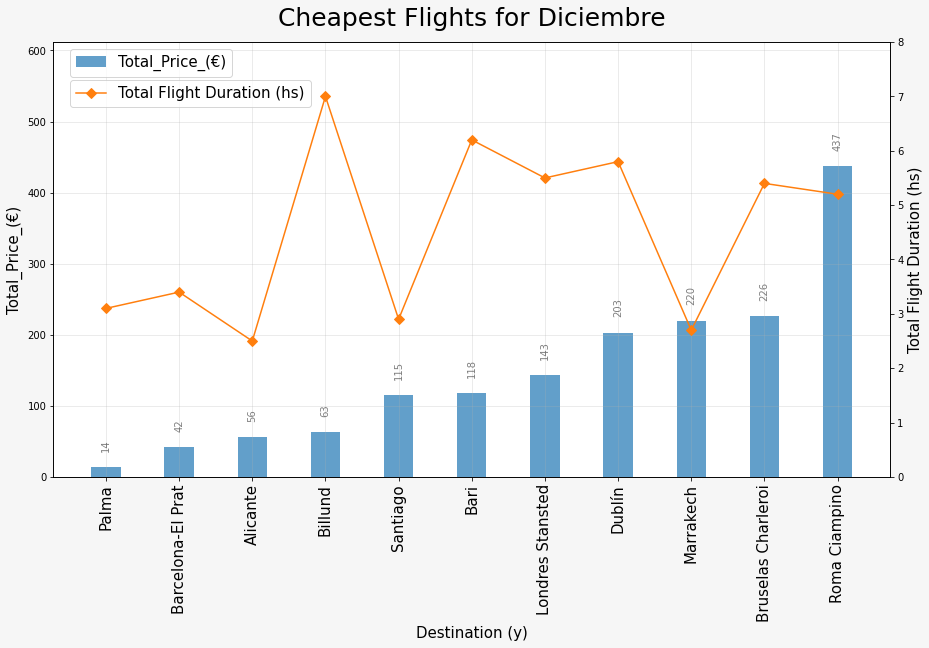

In [21]:
def bar_plot(data, num, cat, aux):
    fig = Figure(figsize=(15,8))
    fig.patch.set_facecolor('#F6F6F6')
    FigureCanvas(fig)
    ax = fig.add_subplot()
    ax2 = ax.twinx()
    month_large = datetime.datetime.strptime(f'{month}.', '%b').strftime('%B').capitalize()
    df = data.groupby(cat).min().sort_values(by = num)

    ax.bar(df.index, df[num], alpha = 0.7, label = df[num].name,width = 0.4)
       
    ax.grid(alpha = 0.3)
    ax.legend(loc=(0.02,0.92), fontsize=15)
    ax.set_title(f"Cheapest Flights for {month_large}", fontsize=25, pad = 16)
    ax.set_xlabel(df.index.name, fontsize=15)
    
    ax.set_ylabel(f"{df[num].name}", fontsize=15)
    
    
    if ax.get_yticks().max() > 1e3:
        ax.set_yticklabels([f"{round(int(x)/1000)}" for x in ax.get_yticks()])
        for i in range(len(df)):
            ax.annotate(str(round(df[num][i]/1000)), xy=(i,df[num][i]+(df[num].max()*.05)),
                        ha='center', va='bottom',rotation = 90,alpha=0.5)
    else:
        for i in range(len(df)):
            ax.annotate(str(round(df[num][i])), xy=(i,df[num][i]+(df[num].max()*.05)), 
                        ha='center', va='bottom',rotation = 90,alpha=0.5)
  
    ax.set_xticklabels(df.index, rotation=90, fontsize=15)
    ax.set_ylim(0,df[num].max()*1.4)
    
#     aux.plot(ax=ax2,kind="line",color="orange",grid=True,label = "Flights Total Duration")
    ax2.plot(df[aux], color="C1", marker="D", ms=7, label = "Total Flight Duration (hs)")
    ax2.set_ylim(0,8)
    ax2.set_ylabel("Total Flight Duration (hs)", fontsize=15)
    ax2.legend(loc=(0.02,0.85), fontsize=15)
    
    plt.show()
    # fig.savefig('output.png')
    return fig

bar_plot(flights_df, "Total_Price_(€)", "Destination (y)","Total_Durac_(hs)")

##### 6.3 Export to csv files

In [20]:
now = datetime.datetime.now()
now_string = now.strftime("%d-%m_%Hh%Mm")

flights_df_dep.to_csv(f"RESULTS\\1_{now_string}_{start}.csv",encoding='utf-8', sep = "\t")
flights_df_arrive.to_csv(f"RESULTS\\2_{now_string}_{start}.csv",encoding='utf-8', sep = "\t")
flights_df.to_csv(f"RESULTS\\3_{now_string}_{start}.csv",encoding='utf-8', sep = "\t")